In [1]:
# Dependencies
#> %matplotlib inline
#> from matplotlib import style
#> style.use('fivethirtyeight') # I don't actually prefer this style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

---
# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

---
# Exploratory Climate Analysis

In [9]:
# Let's first inspect the tables columns
inspector = inspect(engine)

meas_columns = inspector.get_columns('measurement')
print("Measurement:")
for c in meas_columns:
    print(c['name'], c["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations:")
for c in station_columns:
    print(c['name'], c["type"])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [12]:
# Calculate the date 1 year ago from the last data point in the database
final_date = session.query(Measurement.date)\
            .order_by(Measurement.date.desc()).first()
print(f"The last date in the dataset is: {final_date[0]}")

start_date = (dt.datetime.strptime(final_date[0],'%Y-%m-%d') 
              - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"And one year prior is: {start_date}")

The last date in the dataset is: 2017-08-23
And one year prior is: 2016-08-23


In [130]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp)\
            .filter(Measurement.date >= start_date).all()
prcp_query[:3]

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08)]

In [18]:
# Save the query results as a Pandas DataFrame and drop any missing values
prcp_df = pd.DataFrame(prcp_query,columns=['date','precipitation']).dropna()

# Set the index to the date column
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

prcp_df

precipitation
date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15
...                   ...
2017-08-22           0.50
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.45

[2021 rows x 1 columns]

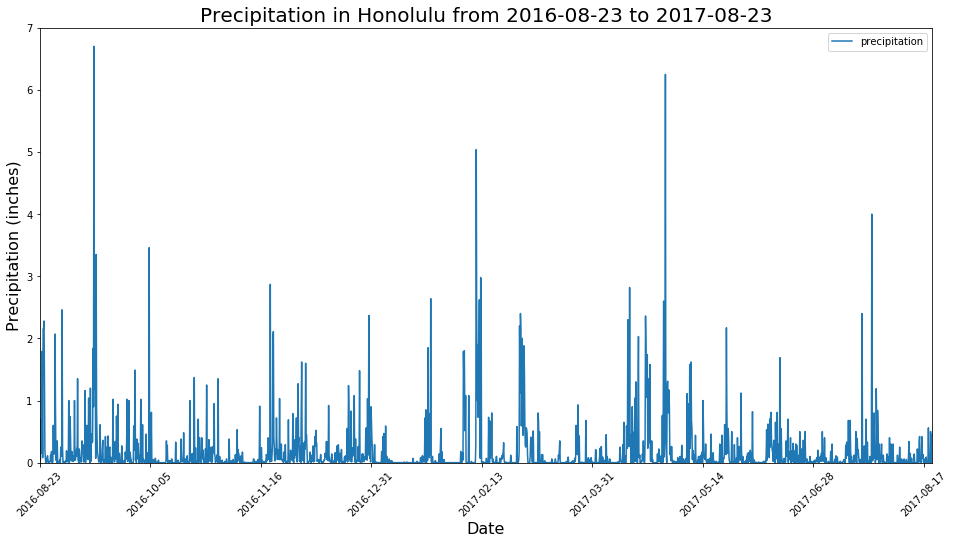

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(16,8), rot=45)
plt.ylim(0,7)
plt.title(f"Precipitation in Honolulu from {start_date} to {final_date[0]}", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.show()

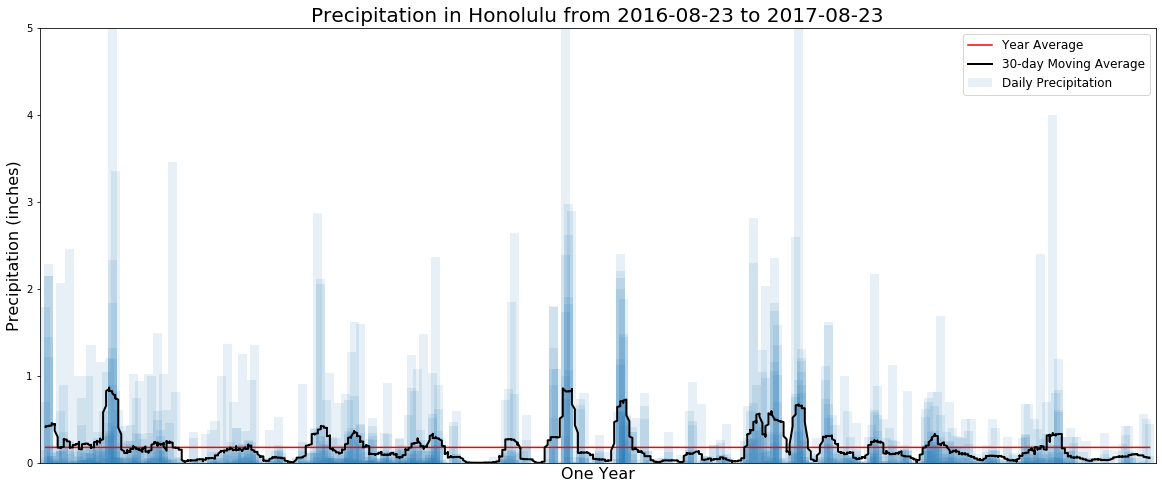

In [138]:
# Just for fun, let's look at the 30-day moving average of rainfall rather than have so many spikes
plt.figure(0,(20,8))

# Same as above but in bar form
plt.bar(prcp_df.index, prcp_df.precipitation, width=3, alpha=0.111, align="center", label='Daily Precipitation')

# Adding the yearly average as a horizontal line
plt.plot(prcp_df.index, [prcp_df.precipitation.mean()]*len(prcp_df), color='red', label='Year Average')

N=30 # We use Numpy's convolve to take a N=30 day moving average
plt.plot(prcp_df.index, np.convolve(prcp_df.precipitation, np.ones((N,))/N, mode='same'), 
         color='black', lw=2, label='30-day Moving Average')

plt.xticks([]) # I could set these but this is really just for the visual anyway 
plt.xlim(-2,367)
plt.ylim(0,5)
plt.title(f"Precipitation in Honolulu from {start_date} to {final_date[0]}", size=20)
plt.xlabel("One Year", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.legend(fontsize=12)
plt.show()

In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

---
# Station Analysis

In [85]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} stations available in the dataset.")

There are 9 stations available in the dataset.


In [139]:
# We can also use the Station dataset to see the station count
station_count = session.query(Station).count()
print(f"There are {station_count} stations available in the dataset.")

There are 9 stations available in the dataset.


In [232]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, 
                                 Station.name, 
                                 func.count(Measurement.tobs))\
                  .filter(Measurement.station == Station.station)\
                  .group_by(Measurement.station)\
                  .order_by(func.count(Measurement.tobs).desc()).all()
station_activity

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [169]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
most_active_station = session.query(func.min(Measurement.tobs), 
                                    func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs))\
                     .filter(Measurement.station == station_activity[0][0])
print(f"The lowest temperature recorded was {most_active_station[0][0]} °F.")
print(f"The highest temperature recorded was {most_active_station[0][1]} °F.")
print(f"The average recorded temperature was {round(most_active_station[0][2],1)} °F.")

The lowest temperature recorded was 54.0 °F.
The highest temperature recorded was 85.0 °F.
The average recorded temperature was 71.7 °F.


In [108]:
# Query the last 12 months of temperature observation data for this station
tobs_query = session.query(Measurement.date, Measurement.tobs)\
            .filter(Measurement.station == station_activity[0][0])\
            .filter(Measurement.date >= start_date).all()
tobs_query[:3]

[('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0)]

In [123]:
# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_query, columns=['date','TOBs'])

# Set the index to the station column
tobs_df.set_index('date', inplace=True)

# Sort the dataframe by TOBs
tobs_df = tobs_df.sort_values('TOBs')

tobs_df

TOBs
date            
2017-02-02  59.0
2017-02-08  59.0
2017-02-09  59.0
2017-04-30  60.0
2017-02-03  60.0
...          ...
2017-03-11  81.0
2017-07-29  82.0
2017-07-23  82.0
2017-08-05  82.0
2017-08-06  83.0

[352 rows x 1 columns]

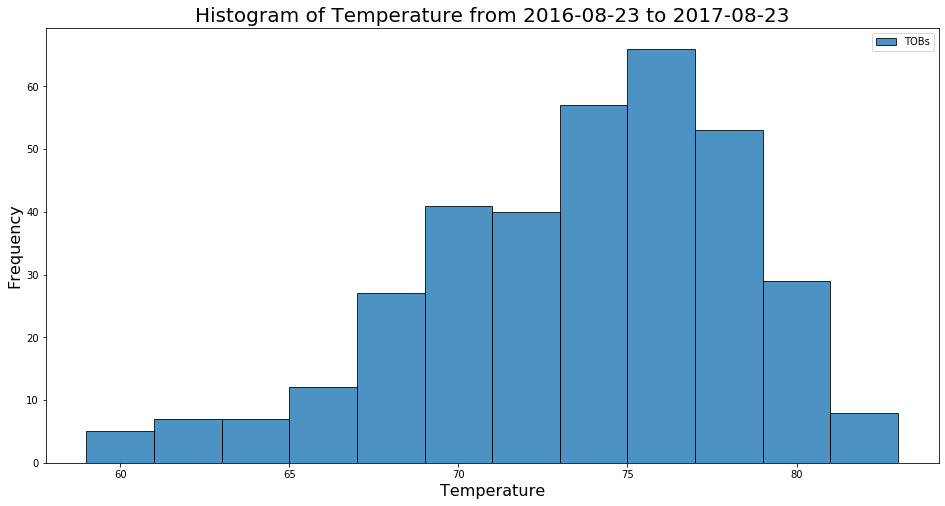

In [129]:
# Plot the histogram
tobs_df.plot(kind= 'hist', bins=12, figsize=(16,8), alpha=0.8, edgecolor='black')
plt.title(f"Histogram of Temperature from {start_date} to {final_date[0]}", size=20)
plt.xlabel("Temperature", size=16)
plt.ylabel("Frequency", size=16)
plt.show()

## Temperature Analysis I

In [347]:
# Let's first take a look at the averages for each month
for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    query = session.query(func.avg(Measurement.tobs))\
            .filter(func.strftime("%m", Measurement.date) == month).all()
    print(f"{month} - {round(query[0][0],2)} °F")

# We don't need to plot that to see that there is a steady rise and fall there, 
# so Honolulu isn't perfectly flat with regards to temperature year round

01 - 68.73 °F
02 - 69.44 °F
03 - 70.06 °F
04 - 72.36 °F
05 - 73.68 °F
06 - 74.94 °F
07 - 76.08 °F
08 - 76.41 °F
09 - 76.16 °F
10 - 75.39 °F
11 - 73.25 °F
12 - 71.04 °F


In [377]:
# Identify the average temperature in June at all stations across all years in the dataset. 
june_query = session.query(Measurement.date, Measurement.tobs)\
                     .filter(func.strftime("%m", Measurement.date) == '06').all()
# Do the same for December.
dec_query = session.query(Measurement.date, Measurement.tobs)\
                     .filter(func.strftime("%m", Measurement.date) == '12').all()

In [378]:
# Extract only the temperatures
june_temps = [result[1] for result in june_query] 
dec_temps = [result[1] for result in dec_query]

We will start by using an unpaired t-test since the arrays have different lengths...

In [379]:
stats.ttest_ind(june_temps, dec_temps)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

But really, we should be using a paired t-test since we are comparing nearly the same data from the same sources collected at two different times. Unfortunately the two sources having different array sizes only allow us to use `ttest_rel()` as follows:

In [386]:
len(june_temps) > len(dec_temps)

True

In [385]:
stats.ttest_rel(june_temps[:len(dec_temps)], dec_temps)

Ttest_relResult(statistic=34.804545051754815, pvalue=1.4623155269997529e-195)

## Temperature Analysis II

In [171]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs))\
          .filter(Measurement.date >= start_date)\
          .filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [230]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

# Christmas in paradise (using 2016 since 2019 isn't in this dataset)
start_date = '2016-12-20'
end_date = '2016-12-27'

tmin, tavg, tmax = calc_temps(start_date, end_date)[0]
print(f"TMIN: {tmin} \nTAVG: {round(tavg,1)} \nTMAX: {tmax}")

TMIN: 68.0 
TAVG: 73.0 
TMAX: 78.0


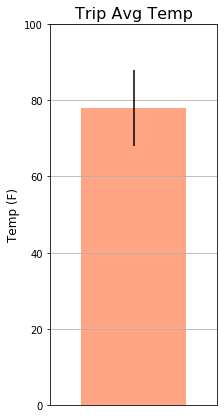

In [231]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(0,(3,7))
plt.bar(0, tmax, yerr = tmax - tmin, color= "coral", align="center", alpha= .7)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.title("Trip Avg Temp", size=16)
plt.ylabel("Temp (F)", size=12)
plt.ylim(0,100)
plt.grid(axis='y')
plt.margins(.3,.3)
plt.show()

## Daily Rainfall Average

In [237]:
# Calculate the total amount of rainfall per weather station for your trip dates 
#  using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list 
#  the station, name, latitude, longitude, and elevation

prcp_query = session.query(Station.station, 
                       Station.name, 
                       Station.latitude, 
                       Station.longitude, 
                       Station.elevation, 
                       func.sum(Measurement.prcp))\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.date >= start_date)\
            .filter(Measurement.date <= end_date)\
            .group_by(Station.name)\
            .order_by(func.sum(Measurement.prcp).desc()).all()

prcp_query

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.7),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.7),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.7800000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.35000000000000003),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.32000000000000006),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05)]

In [238]:
# Let's put that in a df and make it a little more readable
pd.DataFrame(prcp_query, columns=['Station',
                                  'Name',
                                  'Latitude',
                                  'Longitude',
                                  'Elevation',
                                  'Precipitation Sum'])

Station                                    Name  Latitude  Longitude  \
0  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
1  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
2  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
3  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
4  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
5  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   
6  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   

   Elevation  Precipitation Sum  
0      152.4               5.70  
1       32.9               1.70  
2       14.6               0.78  
3       19.5               0.35  
4        7.0               0.32  
5       11.9               0.06  
6        3.0               0.05

In [239]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

#### calculate the daily normals for your trip

In [269]:
# Set the start and end date of the trip
start_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Use the start and end date to create a range of dates
date_list = [start_dt + dt.timedelta(days=x) for x in range((end_dt-start_dt).days+1)]
date_list

# Stip off the year and save a list of %m-%d strings
date_list_general = [date.strftime("%m-%d") for date in date_list]
date_list_general

['12-20', '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27']

In [270]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in date_list_general:
    normals.append(daily_normals(date)[0])

normals

[(65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0)]

In [276]:
# Load the previous query results into a Pandas DataFrame 
#  and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index = date_list, 
                          columns = ['tmin' , 'tavg', 'tmax']) 
normals_df.index.name = "Date"
normals_df

tmin       tavg  tmax
Date                             
2016-12-20  65.0  72.913043  81.0
2016-12-21  67.0  72.139535  78.0
2016-12-22  67.0  71.130435  77.0
2016-12-23  61.0  70.346939  78.0
2016-12-24  62.0  70.062500  78.0
2016-12-25  60.0  71.750000  79.0
2016-12-26  63.0  71.446809  77.0
2016-12-27  62.0  71.916667  79.0

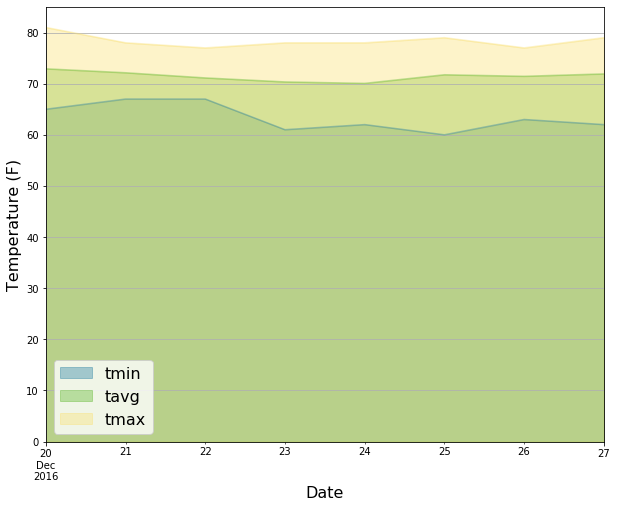

In [310]:
# Plot the daily normals as an area plot with `stacked=False`
palette = ["#2C82A4", "#63B931", "#FAE178"]
normals_df.plot.area(stacked=False, alpha=0.4, colors=palette, figsize=(10,8))
plt.xlabel('Date', size=16)
plt.ylabel('Temperature (F)', size=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()